In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os 
%matplotlib inline
import ase
import subprocess
import re

In [3]:
def osamples(n_samples=1):
    nfpa = np.random.normal(loc=26.42496428571428, scale=0.7598622819300876, size=n_samples)
    nfpa=np.round(nfpa).astype(int)
    gafpa=nfpa*16/28
    gafpa=np.round(gafpa).astype(int)
    ofpa=nfpa-gafpa
    return ofpa[0], gafpa[0]
print(osamples())
#38.757275 1.5456876137742062
def gasamples(n_samples=1):
    nfpa = np.random.normal(loc=38.757275, scale=1.5456876137742062, size=n_samples)
    nfpa=np.round(nfpa).astype(int)
    gafpa=nfpa*30/40
    gafpa=np.round(gafpa).astype(int)
    ofpa=nfpa-gafpa
    return ofpa[0], gafpa[0]
print(gasamples())
def spherical_to_cartesian(r, phi, theta):
    """ convert spherical coordinates (physics convention) to cart. vector
        input angles in DEGREES! """
    phi = np.deg2rad(phi)
    theta = np.deg2rad(theta)
    x = r * np.sin(theta) * np.cos(phi)
    y = r * np.sin(theta) * np.sin(phi)
    z = r * np.cos(theta)
    return np.array([x, y, z])

def random_direction(seed=None):
    """ generate random direction in spherical coordinates """
    np.random.seed(seed)  # when None, seeds from /dev/urandom if available, else clock
    theta = np.arccos(2.0 * np.random.random() - 1)
    phi = 2.0 * np.random.random() * np.pi
    theta = np.rad2deg(theta)
    phi = np.rad2deg(phi)
    return phi, theta

# Sample DataFrame setup (replace this with your actual DataFrame)
# Assuming df is already created with columns ['Particle Identifier', 'Particle Type', 'x', 'y', 'z']

# Function to select sparse points
def select_sparse_points(df, n, min_distance=30):
    selected_indices = []
    attempts = 0  # To prevent infinite loops
    while len(selected_indices) < n and attempts < 1000:
        random_index = np.random.choice(df.index)
        selected_point = df.loc[random_index]

        # Check if this point is sufficiently far from already selected points
        if all(np.linalg.norm(selected_point[['x', 'y', 'z']].values - df.loc[i, ['x', 'y', 'z']].values) >= min_distance for i in selected_indices):
            selected_indices.append(random_index)

        attempts += 1

    return df.loc[selected_indices]
def apply_pbc_distance(df, PKA, radius, xlo, xhi, ylo, yhi, zlo, zhi):
    """
    Apply periodic boundary conditions to calculate the minimum image distance 
    between each atom and the PKA, then filter atoms within a given radius.
    
    Parameters:
        df (pd.DataFrame): DataFrame with atom coordinates.
        PKA (pd.Series): Series representing the PKA coordinates.
        radius (float): The cutoff radius within which atoms are selected.
        xlo, xhi, ylo, yhi, zlo, zhi (float): Box dimensions.

    Returns:
        pd.DataFrame: Filtered DataFrame containing atoms within the radius.
    """
    # Calculate box lengths for each dimension
    box_x = xhi - xlo
    box_y = yhi - ylo
    box_z = zhi - zlo

    # Compute minimum image distance in each direction
    dx = np.abs(df['x'] - PKA['x'])
    dx = np.where(dx > box_x / 2, box_x - dx, dx)

    dy = np.abs(df['y'] - PKA['y'])
    dy = np.where(dy > box_y / 2, box_y - dy, dy)

    dz = np.abs(df['z'] - PKA['z'])
    dz = np.where(dz > box_z / 2, box_z - dz, dz)

    # Calculate the total distance with PBC applied
    distances = np.sqrt(dx**2 + dy**2 + dz**2)

    # Filter atoms within the specified radius
    dff = df[distances <= radius]

    return dff



def displacement(fpas,xlo, xhi, ylo, yhi, zlo, zhi):
    """
    This function takes a DataFrame `fpas` and applies a random displacement 
    directly to the `x`, `y`, and `z` coordinates of each particle. If a displaced 
    position goes outside the box boundaries, it is wrapped back inside using 
    periodic boundary conditions.
    """
    # Reset the index to ensure we have a sequential numeric index
    fpas = fpas.reset_index(drop=True)
    # Box dimensions
    x_length = xhi - xlo
    y_length = yhi - ylo
    z_length = zhi - zlo
    for j in range(fpas.shape[0]):
        # Generate a random displacement distance within a specific range
        r = np.random.uniform(5.8, 6.2)
        
        # Generate random spherical coordinates for direction
        phi, theta = random_direction()
        
        # Convert spherical coordinates to Cartesian displacements
        displace_x, displace_y, displace_z = spherical_to_cartesian(r, phi, theta)
        # Calculate new positions with displacement
        new_x = fpas.at[j, 'x'] + displace_x
        new_y = fpas.at[j, 'y'] + displace_y
        new_z = fpas.at[j, 'z'] + displace_z
        
        # Apply periodic boundary conditions for each axis
        if new_x < xlo:
            new_x += x_length
        elif new_x > xhi:
            new_x -= x_length
            
        if new_y < ylo:
            new_y += y_length
        elif new_y > yhi:
            new_y -= y_length
            
        if new_z < zlo:
            new_z += z_length
        elif new_z > zhi:
            new_z -= z_length
        
        # Update the DataFrame with the new wrapped positions
        fpas.at[j, 'x'] = new_x
        fpas.at[j, 'y'] = new_y
        fpas.at[j, 'z'] = new_z

    return fpas
def apply_displacement_to_df(df, ofpas):
    """
    Apply the updated positions from `ofpas` to the corresponding atoms in `df`.
    
    Parameters:
        df (pd.DataFrame): The original DataFrame containing all atoms.
        ofpas (pd.DataFrame): The DataFrame containing the displaced atoms.
        
    Returns:
        pd.DataFrame: The modified DataFrame with updated positions.
    """
    for index, row in ofpas.iterrows():
        # Extract the Particle Identifier and the updated positions
        particle_id = row['Particle Identifier']
        new_x = row['x']  # Use the updated position
        new_y = row['y']
        new_z = row['z']

        # Locate the corresponding atom in the original df using Particle Identifier
        atom_index = df[df['Particle Identifier'] == particle_id].index
        
        if len(atom_index) > 0:  # Ensure the atom is found
            # Update the positions in df
            df.at[atom_index[0], 'x'] = new_x
            df.at[atom_index[0], 'y'] = new_y
            df.at[atom_index[0], 'z'] = new_z
            

    return df
def write_lammps_data_file(df, box_dimensions, output_file):
    """
    Write a LAMMPS data file with updated positions from the DataFrame.

    Parameters:
        df (pd.DataFrame): DataFrame containing updated atom positions.
        box_dimensions (tuple): The dimensions of the box (xlo, xhi, ylo, yhi, zlo, zhi).
        output_file (str): The path to the output LAMMPS data file.
    """
    xlo, xhi, ylo, yhi, zlo, zhi = box_dimensions

    with open(output_file, 'w') as f:
        # Header
        f.write("LAMMPS data file via write_data, version 3 Aug 2022\n\n")
        f.write(f"{len(df)} atoms\n")
        f.write("5 atom types\n\n")
        f.write(f"{xlo} {xhi} xlo xhi\n")
        f.write(f"{ylo} {yhi} ylo yhi\n")
        f.write(f"{zlo} {zhi} zlo zhi\n\n")
        
        # Masses
        f.write("Masses\n\n")
        f.write("1 69.723\n")
        f.write("2 69.723\n")
        f.write("3 15.999\n")
        f.write("4 15.999\n")
        f.write("5 15.999\n\n")
        
        # Atoms
        f.write("Atoms # atomic\n\n")
        for index, row in df.iterrows():
            f.write(f"{int(row['Particle Identifier'])} {int(row['Particle Type'])} "
                     f"{row['x']} {row['y']} {row['z']} 0 0 0\n")

(11, 14)
(10, 31)


In [16]:


# Path to the LAMMPS data file
#datafile = '/Users/ruhe/Desktop/ga2o3/beta/fpa_mic_overlap/data.lastframe_90'
#output_file = '/Users/ruhe/Desktop/ga2o3/beta/fpa_mic_overlap/data.lastframe_120'
for n_pka in range(30,60,30):
    n_pka_after=n_pka+30
    datafile='/home/heruhe/Desktop/data.lastframe_{}'.format(n_pka)
    output_file = '/home/heruhe/Desktop/data.lastframe_{}'.format(n_pka_after)
    # Initialize variables for the box dimensions
    xlo, xhi, ylo, yhi, zlo, zhi = None, None, None, None, None, None

    # Read through the file to find the box limits
    with open(datafile, 'r') as file:
        for line in file:
            # Search for xlo xhi, ylo yhi, and zlo zhi lines using regex
            x_match = re.match(r"(-?\d+\.\d+)\s+(-?\d+\.\d+)\s+xlo xhi", line)
            y_match = re.match(r"(-?\d+\.\d+)\s+(-?\d+\.\d+)\s+ylo yhi", line)
            z_match = re.match(r"(-?\d+\.\d+)\s+(-?\d+\.\d+)\s+zlo zhi", line)
        
            if x_match:
                xlo, xhi = float(x_match.group(1)), float(x_match.group(2))
            elif y_match:
                ylo, yhi = float(y_match.group(1)), float(y_match.group(2))
            elif z_match:
                zlo, zhi = float(z_match.group(1)), float(z_match.group(2))

    # Display extracted values
    print("xlo:", xlo, "xhi:", xhi)
    print("ylo:", ylo, "yhi:", yhi)
    print("zlo:", zlo, "zhi:", zhi)



    df=pd.read_csv(datafile, skiprows = 19, nrows=81920,sep="\s+",header=None)
    #print(df.describe())
    df.columns=['Particle Identifier','Particle Type','x','y','z','p1','p2','p3']
    df = df.apply(lambda col: pd.to_numeric(col, errors='coerce'))
    npka=30
    PKAs= select_sparse_points(df, npka, min_distance=30)
    print(PKAs.shape)

    for ni in range(PKAs.shape[0]):
        PKA = PKAs.iloc[ni]
        #print(PKA)
        if PKA['Particle Type']<3:
            # Calculate radial distance
            radius = 15
            dff = apply_pbc_distance(df, PKA, radius, xlo, xhi, ylo, yhi, zlo, zhi)
    
            # Print the filtered DataFrame
            dffo=dff[dff['Particle Type']>2]
            dffga=dff[dff['Particle Type']<3]
            nofpa,ngafpa=gasamples()
            #print(nofpa,ngafpa)
            ofpas=dffo.sample(n=nofpa, replace=False)
            #print(ofpas)
            gafpas=dffga.sample(n=ngafpa, replace=False)
            #print(gafpas)
            ofpas=displacement(ofpas,xlo, xhi, ylo, yhi, zlo, zhi)
            gafpas=displacement(gafpas,xlo, xhi, ylo, yhi, zlo, zhi)
            # Apply updated positions from ofpas to df
            df = apply_displacement_to_df(df, ofpas)
            # Apply updated positions from gafpas to df
            df = apply_displacement_to_df(df, gafpas)
            #print(ofpas)
        
        else:
            # Calculate radial distance
            radius = 30
            dff = apply_pbc_distance(df, PKA, radius, xlo, xhi, ylo, yhi, zlo, zhi)
    
            # Print the filtered DataFrame
            dffo=dff[dff['Particle Type']>2]
            dffga=dff[dff['Particle Type']<3]
            #print(len(dffga),len(dffo))
            nofpa,ngafpa=gasamples()
            #print(nofpa,ngafpa)
            ofpas=dffo.sample(n=nofpa, replace=False)
            #print(ofpas)
            gafpas=dffga.sample(n=ngafpa, replace=False)
            #print(gafpas)
            ofpas=displacement(ofpas,xlo, xhi, ylo, yhi, zlo, zhi)
            gafpas=displacement(gafpas,xlo, xhi, ylo, yhi, zlo, zhi)
            # Apply updated positions from ofpas to df
            df = apply_displacement_to_df(df, ofpas)
            # Apply updated positions from gafpas to df
            df = apply_displacement_to_df(df, gafpas)


    box_dimensions = (xlo, xhi, ylo, yhi, zlo, zhi)  # You should define these dimensions
    write_lammps_data_file(df, box_dimensions, output_file)
    if n_pka_after % 90 == 0:
        lammps ='srun /projappl/djurabek/heru/lammps/build/lmp'

        inputfile = "in.minimize"
        run_lammps = str(lammps) + ' -in ' + inputfile + ' -var times ' + str(n_pka_after)
        subprocess.call(run_lammps, stdout=lmpout, shell=True)


xlo: -0.14382181802644567 xhi: 97.00039890169826
ylo: -0.14662306115980783 yhi: 98.8896929257671
zlo: -0.13968427372114434 zhi: 94.20983865391295
(30, 8)


In [ ]:
def writeLmpIn(locout, npka, ofpas, gafpas, name="default_name", remote="no", time=1000):
    """
    Write an input file for LAMMPS.
    
    Parameters:
    locout: str
        Output path for the input file.
    npka: int
        Number of PKA (Primary Knock-on Atoms).
    ofpas: DataFrame
        DataFrame containing information about the first set of PKA.
    gafpas: DataFrame
        DataFrame containing information about the second set of PKA.
    name: str, optional
        Name string for the simulation (default is 'default_name').
    remote: str, optional
        Indicates whether to use remote paths for potential files (default is 'no').
    time: int, optional
        Total time step for the simulation (default is 1000).
    """
    
    with open(locout, "w") as wt:
        # Write basic simulation parameters
        wt.write("variable \t name string '%s' \n" % name)
        wt.write("\n")
        wt.write("units \t metal \n")
        wt.write("atom_style	 \t atomic \n")
        wt.write("boundary \t p p p \n")
        wt.write("neighbor \t 2.0 bin \n")
        wt.write("neigh_modify \t delay 0 every 1 check yes \n")
        wt.write("\n")
        
        # Log and data input
        wt.write("log \t log.${npka} \n")
        wt.write("\n")
        wt.write("read_data data.beta_last \n")
        wt.write("\n")
        
        # Define masses for atom types
        wt.write("mass 1 69.723\n")
        wt.write("mass 2 69.723\n")
        wt.write("mass 3 15.9994\n")
        wt.write("mass 4 15.9994\n")
        wt.write("mass 5 15.9994\n")
        wt.write("\n")
        
        # Define pair styles and coefficients
        wt.write("pair_style	 \t hybrid/overlay eam/fs tabgap \n")
        if remote == "no":
            wt.write("pair_coeff	 \t * * eam/fs /home/heruhe/Desktop/Ga2o3/potential/Ga-O_20220921.eam.fs Ga Ga O O O \n")
            wt.write("pair_coeff	 \t * * tabgap /home/heruhe/Desktop/Ga2o3/potential/Ga-O_20220921.tabgap Ga Ga O O O no yes \n")
        elif remote == "yes":
            wt.write("pair_coeff	 \t * * eam/fs /scratch/djurabek/heru/ga2o3/potential/Ga-O_20220921.eam.fs Ga Ga O O O \n")
            wt.write("pair_coeff	 \t * * tabgap /scratch/djurabek/heru/ga2o3/potential/Ga-O_20220921.tabgap Ga Ga O O O no yes \n")
        else:
            raise ValueError("The remote parameter should be either 'yes' or 'no'.")
        
        wt.write("\n")
        
        # Define thermodynamic variables
        wt.write("variable	 \t ape equal pe/atoms \n")
        wt.write("variable	 \t ake equal ke/atoms \n")
        wt.write("variable	 \t avol equal vol/atoms \n")
        wt.write("compute	 \t ep all pe/atom \n")
        wt.write("compute	 \t ek all ke/atom \n")
        wt.write("\n")

        # Thermo settings
        wt.write("thermo	 \t 100 \n")
        wt.write("thermo_style \t custom step dt time temp press v_ape v_ake etotal pxx pyy pzz lx ly lz v_avol \n")
        wt.write("thermo_style \t lost warn line one flush yes format 1 \"ec %8lu\" format float \"%14.10g\" \n")
        wt.write("\n")

        # Loop through `ofpas` DataFrame to write PKA displacements
        for i in range(ofpas.shape[0]):
            PKAID = ofpas.iloc[i]['Particle Identifier']
            dis_x = ofpas.iloc[i]['displace_x']
            dis_y = ofpas.iloc[i]['displace_y']
            dis_z = ofpas.iloc[i]['displace_z']
            wt.write("\n")
            wt.write(f"group fp id {PKAID}\n")  # Using f-string for clarity
            wt.write(f"displace_atoms fp move {dis_x} {dis_y} {dis_z}\n")
        
        # Loop through `gafpas` DataFrame to write additional PKA displacements
        for i in range(gafpas.shape[0]):
            PKAID = gafpas.iloc[i]['Particle Identifier']
            dis_x = gafpas.iloc[i]['displace_x']
            dis_y = gafpas.iloc[i]['displace_y']
            dis_z = gafpas.iloc[i]['displace_z']
            wt.write("\n")
            wt.write(f"group fp id {PKAID}\n")  # Using f-string for clarity
            wt.write(f"displace_atoms fp move {dis_x} {dis_y} {dis_z}\n")
        
        # Final commands for simulation
        wt.write("min_style \t cg \n")
        wt.write("minimize \t 1e-5 1e-6 10000 10000 \n")
        wt.write("\n")
        wt.write("velocity \t all create 600 666 mom yes rot yes dist gaussian units box \n")
        wt.write("fix \t 1 all npt temp 300 300 0.1 aniso 0.0 0.0 1.0 \n")
        wt.write(f"dump  mydump all custom 100 dumpfiles/dump._{npka} id type x y z c_ep c_ek \n")
        wt.write("timestep \t 0.002 \n")
        wt.write(f"run \t {time}\n")
        wt.write("\n")
        wt.write(f"write_data \t out/data.lastframe_{npka}\n")
        wt.write("write_data \t data.beta_last\n")


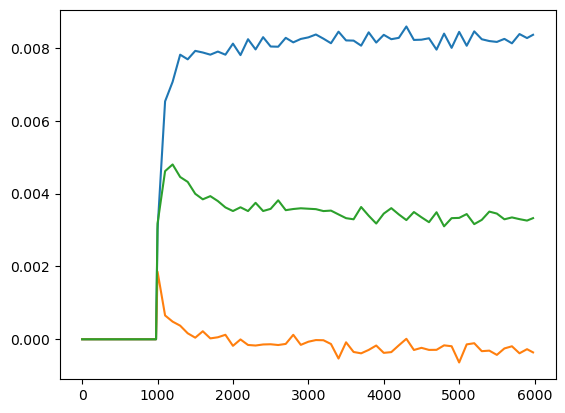

In [38]:
import lammps_logfile
fn='/Users/ruhe/Desktop/ga2o3/beta/fpa_mic_overlap/log.30'

log = lammps_logfile.File(fn)
plt.plot(log.get('Step'),(log.get("Lx")-log.get("Lx")[0])/log.get("Lx")[0])
plt.plot(log.get('Step'),(log.get("Ly")-log.get("Ly")[0])/log.get("Ly")[0])
plt.plot(log.get('Step'),(log.get("Lz")-log.get("Lz")[0])/log.get("Lz")[0])


20.40503411791193 0.0031268756296879514
47 [100, 110, 120, 130, 130, 130, 140, 140, 140, 150, 150, 150, 150, 140, 140, 130, 130, 120, 110, 100, 90, 80, 70, 60, 50, 50, 40, 30, 20, 20, 20, 10, 10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


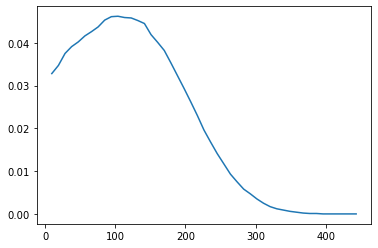

In [4]:
#quick cascade
fluence=2*10**13
path='/home/heruhe/Desktop/Ga2o3/combine_cells/SRIM/quick_calculation'
fn=path+'/400keV-Ni-Ga2O3-KP-He.txt'
# Read the CSV file with specified parameters
df = pd.read_csv(fn, skiprows=4,  sep=r'\s+', names=['depth','dpa'],header=None)
srim_dpa=df['dpa']/(2*10**13)*2*10**13
plt.plot(df['depth'],srim_dpa)

#function to calculate displacements-per-atom (dpa)
def DPA(E,npka,estop,n,TDE):
    #input E:recoil energy
    #npka:cascade times
    #estop:electronic stopping power,obtained by lammps logfile output stable 'f_elstop'
    #n:number of atoms
    #TDE: lattice dis-placement energy
    #output: dpa value
    Td=E-estop
    return npka*0.8*Td/(2*TDE*n)
TDEO1=17.44
TDEO2=17.38
TDEO3=17.07
TDEGa1=22.91
TDEGa2=20.04
mO=15.9994
mGa=69.72
TDEga2o3=((TDEO1+TDEO2+TDEO3)*mO+(TDEGa1+TDEGa2)*mGa)/(2*mGa+3*mO)
print(TDEga2o3,DPA(1500,10,193.294,81920,TDEga2o3))
def PKA(E,dpa,estop,n,TDE):
    #input E:recoil energy
        #dpa:dpa value
        #estop:electronic stopping power,obtained by lammps logfile output stable 'f_elstop'
        #n:number of atoms
        #TDE: lattice dis-placement energy
    #output: npka cascade times
    Td=E-estop
    return (2*TDE*n*dpa)/(0.8*Td)

pkal=[]
for i in range(len(srim_dpa)):
    dpa=srim_dpa.iloc[i]
    #print(dpa)
    pka_dpa=PKA(1500,dpa,193.294,81920,TDEga2o3)
 
    pka=round(pka_dpa / 10) * 10
    #print(pka_dpa,pka)
    pkal.append(pka)
print(len(pkal),pkal)

In [35]:
def displacement_cell(dfcell,npka,xlo, xhi, ylo, yhi):
    PKAs= select_sparse_points(dfcell, npka, min_distance=10)
    for ni in range(PKAs.shape[0]):
        PKA = PKAs.iloc[ni]
        #print(PKA)
        if PKA['Particle Type']<3:
            # Calculate radial distance
            radius = 15
            dff = apply_pbc_distance(dfcell, PKA, radius, xlo, xhi, ylo, yhi, zlo, zhi)
            #print(dff)
    
            # Print the filtered DataFrame
            dffo=dff[dff['Particle Type']==2]
            dffga=dff[dff['Particle Type']==1]
            nofpa,ngafpa=gasamples()
            gafpas=dffga.sample(n=ngafpa, replace=False)
            gafpas=displacement(gafpas,xlo, xhi, ylo, yhi, zlo, zhi)
            dfcell = apply_displacement_to_df(dfcell, gafpas)
    return dfcell

    

In [44]:
def write_lammps_data_file_2type(df, box_dimensions, output_file):
    """
    Write a LAMMPS data file with updated positions from the DataFrame.

    Parameters:
        df (pd.DataFrame): DataFrame containing updated atom positions.
        box_dimensions (tuple): The dimensions of the box (xlo, xhi, ylo, yhi, zlo, zhi).
        output_file (str): The path to the output LAMMPS data file.
    """
    xlo, xhi, ylo, yhi, zlo, zhi = box_dimensions

    with open(output_file, 'w') as f:
        # Header
        f.write("LAMMPS data file via write_data, version 3 Aug 2022\n\n")
        f.write(f"{len(df)} atoms\n")
        f.write("2 atom types\n\n")
        f.write(f"{xlo} {xhi} xlo xhi\n")
        f.write(f"{ylo} {yhi} ylo yhi\n")
        f.write(f"{zlo} {zhi} zlo zhi\n\n")
        
        # Masses
        f.write("Masses\n\n")
        f.write("1 69.723\n")
        f.write("2 15.999\n\n")
        
        # Atoms
        f.write("Atoms # atomic\n\n")
        for index, row in df.iterrows():
            f.write(f"{int(row['Particle Identifier'])} {int(row['Particle Type'])} "
                     f"{row['x']} {row['y']} {row['z']} \n")

In [41]:

datafile='/home/heruhe/Desktop/Ga2o3/cascade/5type_overlapping/FPA_mic_overlap/47cells0'
output_file = '/home/heruhe/Desktop/Ga2o3/cascade/5type_overlapping/FPA_mic_overlap/47cells{:.0e}'.format(fluence)
# Initialize variables for the box dimensions
xlo, xhi, ylo, yhi, zlo, zhi = None, None, None, None, None, None

# Read through the file to find the box limits
with open(datafile, 'r') as file:
    for line in file:
            # Search for xlo xhi, ylo yhi, and zlo zhi lines using regex
        x_match = re.match(r"(-?\d+\.\d+)\s+(-?\d+\.\d+)\s+xlo xhi", line)
        y_match = re.match(r"(-?\d+\.\d+)\s+(-?\d+\.\d+)\s+ylo yhi", line)
        z_match = re.match(r"(-?\d+\.\d+)\s+(-?\d+\.\d+)\s+zlo zhi", line)
        
        if x_match:
            xlo, xhi = float(x_match.group(1)), float(x_match.group(2))
        elif y_match:
            ylo, yhi = float(y_match.group(1)), float(y_match.group(2))
        elif z_match:
            zlo, zhi = float(z_match.group(1)), float(z_match.group(2))
box_dimensions = (xlo, xhi, ylo, yhi, zlo, zhi) 
# Display extracted values
print("xlo:", xlo, "xhi:", xhi)
print("ylo:", ylo, "yhi:", yhi)
print("zlo:", zlo, "zhi:", zhi)

xlo: 0.0 xhi: 96.85657708
ylo: 0.0 yhi: 4640.92428364
zlo: 0.0 zhi: 94.07015438


In [37]:
df=pd.read_csv(datafile, skiprows = 14,sep="\s+",header=None)
df.columns=['Particle Identifier','Particle Type','x','y','z']
df = df.apply(lambda col: pd.to_numeric(col, errors='coerce'))
# Sort DataFrame by y-position
df_sorted = df.sort_values(by='y').reset_index(drop=True)

# Define the number of atoms per cell
atoms_per_cell = 81920

# Number of cells to create
ncell = len(df) // atoms_per_cell

# Split the DataFrame into cells
cells = [df_sorted.iloc[i * atoms_per_cell:(i + 1) * atoms_per_cell] for i in range(ncell)]

# Check the first cell
cells[0]

,Particle Identifier,Particle Type,x,y,z
0,2887882,1,88.884547,0.000000,11.838276
1,963099,2,46.446375,0.000000,40.983785
2,1926371,2,62.637164,0.000000,93.928732
3,1926374,2,62.517274,0.000000,91.282108
4,1926376,2,66.637804,0.000000,94.009426
...,...,...,...,...,...
81915,982195,2,36.272309,97.200209,33.850305
81916,982277,2,32.369484,97.200209,36.608109
81917,982280,2,32.249594,97.200209,39.840869
81918,982227,1,43.463518,97.200209,35.264524


In [38]:
# Calculate min and max y for each cell
y_bounds = [(cell['y'].min(), cell['y'].max()) for cell in cells]

# Display the y-bounds for each cell
after_displaced_df=[]
for cell, (y_min, y_max) in enumerate(y_bounds):
    print(f"Cell {cell+1}: Min y = {y_min}, Max y = {y_max}")
    npka = pkal[cell]
    print(npka)
    dfcell = displacement_cell(cells[cell], npka, xlo, xhi, y_min,y_max)
    after_displaced_df.append(dfcell)


Cell 47: Min y = 0.0, Max y = 97.2002094
100
Cell 47: Min y = 98.74306986, Max y = 195.94327926
110
Cell 47: Min y = 197.48613973, Max y = 294.68634913
120
Cell 47: Min y = 296.22920959, Max y = 393.42941899
130
Cell 47: Min y = 394.97227946, Max y = 492.17248886
130
Cell 47: Min y = 493.71534932, Max y = 590.91555872
130
Cell 47: Min y = 592.45841919, Max y = 689.65862859
140
Cell 47: Min y = 691.20148905, Max y = 788.40169845
140
Cell 47: Min y = 789.94455892, Max y = 887.14476831
140
Cell 47: Min y = 888.68762878, Max y = 985.88783818
150
Cell 47: Min y = 987.43069865, Max y = 1084.63090804
150
Cell 47: Min y = 1086.17376851, Max y = 1183.37397791
150
Cell 47: Min y = 1184.91683838, Max y = 1282.11704777
150
Cell 47: Min y = 1283.65990824, Max y = 1380.86011764
140
Cell 47: Min y = 1382.4029781, Max y = 1479.6031875
140
Cell 47: Min y = 1481.14604797, Max y = 1578.34625737
130
Cell 47: Min y = 1579.88911783, Max y = 1677.08932723
130
Cell 47: Min y = 1678.6321877, Max y = 1775.83239

In [39]:
# Merge the list of dataframes into a single dataframe
merged_df = pd.concat(after_displaced_df, ignore_index=True)

# Display the merged dataframe
print(merged_df)

         Particle Identifier  Particle Type          x            y          z
0                    2887882              1  88.884547     0.000000  11.838276
1                     963099              2  46.446375     0.000000  40.983785
2                    1926371              2  62.637164     0.000000  93.928732
3                    1926374              2  62.517274     0.000000  91.282108
4                    1926376              2  66.637804     0.000000  94.009426
...                      ...            ...        ...          ...        ...
3850235              2886547              1  67.677662  4639.381423  11.746986
3850236              2886546              1  70.723939  4639.381423  10.365053
3850237              2886544              1  65.500131  4639.381423   8.810598
3850238              2886590              2  48.477196  4639.381423  16.117711
3850239              3850240              2  92.784954  4639.381423  89.808884

[3850240 rows x 5 columns]


In [43]:
write_lammps_data_file_2type(merged_df, box_dimensions, output_file)